# Paquetes y seteo

In [96]:
%%time

!pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph
!pip install -qU langchain-chroma



CPU times: total: 156 ms
Wall time: 1min 17s


In [144]:
import nest_asyncio
import getpass
import os
from dotenv import load_dotenv
import pprint

from langchain_ollama import OllamaEmbeddings
from ollama import Client
import ollama
from langchain.chat_models import init_chat_model
from langchain_chroma import Chroma
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

from langchain import hub
from langchain_core.documents import Document
from typing_extensions import List, TypedDict

nest_asyncio.apply()
load_dotenv()

True

In [ ]:
# LangSmith set up y credenciales

LANGSMITH_TRACING= True
LANGSMITH_API_KEY = os.getenv("LANGSMITH_API_KEY")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

# Componentes

## LLM

In [124]:
# llm = init_chat_model("gpt-4o-mini", model_provider="openai")
llm = init_chat_model("deepseek-r1:1.5b"
                      ,model_provider="ollama"
                      , temperature =0)

In [125]:
_ = llm.invoke('Es el español tu mejor idioma? En que idioma es mejor tu performace?')

In [127]:
# for i in dir(_):
#     print(i)
pprint.pprint(_.content)

('<think>\n'
 "Okay, so I'm trying to figure out if Spanish is my best language. I know "
 "that I've been learning a few languages before, but I'm not sure how it "
 'stacks up against others. Let me think through this step by step.\n'
 '\n'
 "First, I should consider what makes a language good. It's probably about how "
 'well you can communicate, adapt to different situations, and maybe even the '
 "cultural aspects of your native tongue. But since I don't have any specific "
 'experiences or data on my performance in other languages, it might be hard '
 'to compare myself directly.\n'
 '\n'
 "I remember that when someone says they're the best in a language, they often "
 'talk about how easy it is to learn, their adaptability, and maybe even how '
 'well they can use the language in real-life situations. So, I should think '
 'about what aspects of Spanish make it stand out from others.\n'
 '\n'
 "Spanish has a rich history, which probably means there's a lot of cultural "
 "richne

## Embeddings Model

In [122]:
ollama_client = Client()

# ollama_client.pull_model("nomic-embed-text")
embeddings = OllamaEmbeddings(model="nomic-embed-text")

In [130]:
ollama.embeddings(model='nomic-embed-text', prompt='The sky is blue because of rayleigh scattering')

EmbeddingsResponse(embedding=[0.590109646320343, 0.40178176760673523, -3.3058652877807617, -0.5256822109222412, 0.7499922513961792, 1.5193517208099365, -0.1249079555273056, 0.39666983485221863, 0.06764353066682816, -1.108612060546875, 0.6921671032905579, 1.2788032293319702, 1.1457455158233643, 1.0878791809082031, 0.2515486776828766, 0.29292455315589905, 0.15189805626869202, -0.6339876651763916, -0.21004678308963776, -0.19574125111103058, -1.7954970598220825, -0.6291620135307312, 0.03792550414800644, -0.6676092743873596, 1.261998176574707, 1.2769657373428345, -0.15988940000534058, -0.0016120619839057326, -0.2979106605052948, -0.47986987233161926, 1.2058753967285156, -0.638171911239624, -0.5402648448944092, -1.0353238582611084, 0.6307409405708313, -1.2089308500289917, 0.6830440759658813, -0.05876900255680084, -0.19687069952487946, 0.12817375361919403, -0.014713982120156288, -0.5535027980804443, 0.35166653990745544, 0.0446397103369236, 0.5973034501075745, -0.9544752836227417, 0.5082449913

## Vector Store

In [131]:
vector_store = Chroma(embedding_function=embeddings)

# Indexing

In [132]:
file_path = "./Docs/dspy.pdf"
loader = PyPDFLoader(file_path)
docs = loader.load()
len(docs)

32

In [133]:
pprint.pp(docs[0].metadata)

{'producer': 'pdfTeX-1.40.25',
 'creator': 'LaTeX with hyperref',
 'creationdate': '2023-10-06T00:32:07+00:00',
 'author': '',
 'keywords': '',
 'moddate': '2023-10-06T00:32:07+00:00',
 'ptex.fullbanner': 'This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live '
                    '2023) kpathsea version 6.3.5',
 'subject': '',
 'title': '',
 'trapped': '/False',
 'source': './Docs/dspy.pdf',
 'total_pages': 32,
 'page': 0,
 'page_label': '1'}


# Splitting Documents


In [134]:

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)

all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 145 sub-documents.


# Storing documents

In [135]:
document_ids = vector_store.add_documents(documents=all_splits)

# Retrieval and Generation

In [138]:
# Example of prompt for RAG
prompt = hub.pull("rlm/rag-prompt")

c:\Users\dario\Documents\GitHub\llms\.venv\Lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [143]:
prompt

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


# LangGraph

## State

In [ ]:
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

## Nodes o steps

In [146]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [147]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

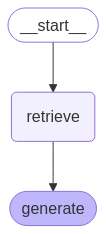

In [148]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [149]:
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='59f2aef4-ff1c-493b-aec7-0a351e10cd89', metadata={'author': '', 'creationdate': '2023-10-06T00:32:07+00:00', 'creator': 'LaTeX with hyperref', 'keywords': '', 'moddate': '2023-10-06T00:32:07+00:00', 'page': 6, 'page_label': '7', 'producer': 'pdfTeX-1.40.25', 'ptex.fullbanner': 'This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) kpathsea version 6.3.5', 'source': './Docs/dspy.pdf', 'start_index': 2282, 'subject': '', 'title': '', 'total_pages': 32, 'trapped': '/False'}, page_content='compiler supports is modifying the control flow of the program. One of the simplest forms of\nthese is ensembles, which we use in the case studies in this work. An ensemble will bootstrap\nmultiple copies of the same program, and then replace the program with a new one that runs them\nall in parallel and reduces their predictions into one with a custom function (e.g., majority voting).\nIn future work, this stage can easily accommodate techniques for more dynamic (i.e., te